In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from multiprocessing import Pool
import functools
import seaborn


sys.path.append("../functions")

from Utils import *
from Forward import forward_fitting, simulate_agent
from Backward import fit_model_backward


%matplotlib inline

In [3]:
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "hc")
subjects = lv_induction_data["sub"].unique()


In [4]:
def calc_metrl(n_trials, subj):
    n_fitting = 100
    params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
    inpt_d = get_task_info(lv_induction_data, subj)
    for k,v in inpt_d.items():
        inpt_d[k] = v[:n_trials]
    inpt_d["n_fitting"] = n_fitting
    inpt_d["params_ranges"] = params_ranges
    
    mrls = []
    
    forward_params,_,_ = forward_fitting(inpt_d)

    backward_params,_,_ = backward_fitting(inpt_d)
    trials_info = get_subject_task(lv_induction_data, subj)[:n_trials]
    n_simulation = 100
    for i in range(n_simulation):
        resps, rewards, acc, confs, Q_list = simulate_agent(forward_params, trials_info)
        forward_perf = np.mean(acc)
        resps, rewards, acc, confs, Q_list = simulate_agent(backward_params, trials_info)
        backward_perf = np.mean(acc)
        mrls.append(backward_perf/forward_perf)
    return np.mean(mrls)

In [ ]:
res = []
for subj in subjects:
    p_func = functools.partial(calc_metrl, subj = subj)
    with Pool(n_threads) as p:
        result = np.array(p.map(p_func, trials_length))
    res.append(result)
    
residuals = []
subjects = []
trials = []
for i, r in enumerate(res):
    residuals.extend(r-r[-1])
    subjects.extend(len(r)*[i])
    trials.extend(trials_length)

df = pd.DataFrame(zip(subjects, trials, residuals), columns= ["sub", "trials", "residuals"])
df.to_csv("../results/n_trials_mrl.csv")

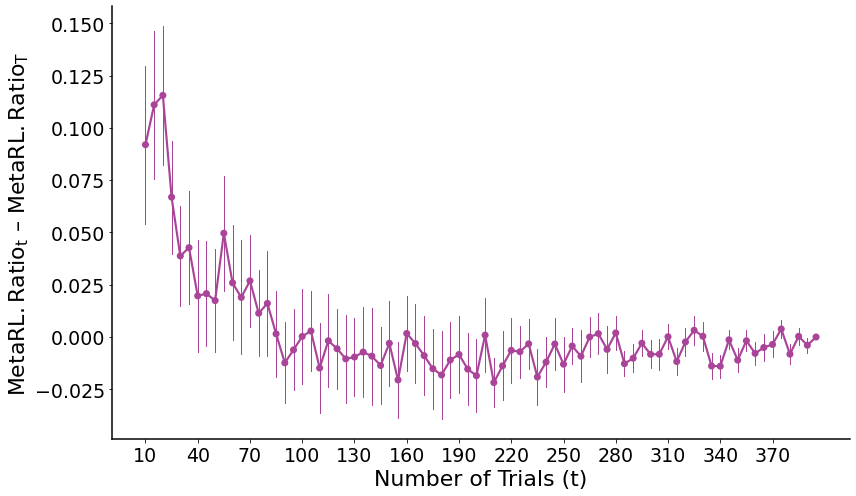

In [5]:
plt.figure(figsize = (12,7))
df = pd.read_csv("../results/n_trials_mrl.csv")
seaborn.pointplot(
    data=df,
    x="trials",
    y="residuals",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    color="#AA4499"
)
ax = plt.gca()

plt.ylabel(r"$MetaRL.Ratio_t $" +" – "  +r"$ MetaRL.Ratio_T$", fontsize=22)
plt.xlabel("Number of Trials (t)", fontsize=22)

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.rcParams.update({'mathtext.default':  'regular' })


plt.locator_params(axis='x', nbins = 15)

plt.tight_layout()
plt.savefig("../figs/Supp_fig8.png", dpi=400, bbox_inches = "tight")


plt.show()